In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from typing import cast, Any, Union, Dict, List
import time
import random
import copy 
import matplotlib.pyplot as plt
from IPython.display import Image
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
#Set a training sample of 5k
train_df = pd.read_csv("archive/fashion-mnist_train.csv")

train_df=train_df.sample(5000)

In [3]:
#Set a testing sample of the whole 10k
test_df = pd.read_csv("archive/fashion-mnist_test.csv")

In [4]:
train, val = train_test_split(train_df, test_size=0.001, shuffle=True, random_state=9)

In [5]:
val = test_df

In [6]:
#mean and standart deviation for normalization
sample_mean = np.mean(train.iloc[:,1:].values)/255
sample_std = np.std(train.iloc[:,1:].values)/255

In [7]:
#Data augmentation
aug1_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                           transforms.RandomRotation(25),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomAffine(degrees=15, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((sample_mean), (sample_std)) 
])

aug2_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.RandomVerticalFlip(p=0.6),
                           transforms.RandomRotation(40),
                           transforms.RandomHorizontalFlip(p=1),
                           transforms.RandomAffine(degrees=30, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((sample_mean), (sample_std)) 
])

aug3_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.RandomRotation(degrees=(-90, 90)),
                           transforms.RandomVerticalFlip(p=0.6),
                           transforms.RandomRotation(40),
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((sample_mean), (sample_std)) 
])


aug4_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                           transforms.RandomRotation(degrees=(-90, 90)),
                           transforms.RandomVerticalFlip(p=0.6),
                           transforms.RandomRotation(70),
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((sample_mean), (sample_std)) 
])

train_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((sample_mean), (sample_std))    
])

val_transformers = transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.ToTensor(),
                           #after calculating the mean and standard deviation.
                           transforms.Normalize((sample_mean), (sample_std))
])

In [8]:
#MyDataSet class to obtain augmented training data
class MyDataSet(Dataset):
  def __init__(self, features, labels, Transform):
    self.x = features
    self.y = labels
    self.transform = Transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.transform(self.x[index]), self.y[index]

In [9]:
def GetDf(df, Transform):
  x_train = df.iloc[:, 1:].values
  y_train = df.label.values
  x_train = x_train.reshape(-1, 1, 28, 28)
  x_train = np.uint8(x_train)
  y_train = torch.from_numpy(y_train).type(torch.LongTensor)
  x_train = torch.from_numpy(x_train)
  return MyDataSet(x_train, y_train, Transform)

In [10]:
#augmentation and data loaders
datasets = {
    'aug1':  GetDf(train_df, aug1_transformers),
    'aug2':  GetDf(train_df, aug2_transformers),
    'aug3':  GetDf(train_df, aug3_transformers),
    'aug4':  GetDf(train_df, aug4_transformers),
    'train': GetDf(train, train_transformers),
    'val': GetDf(val, val_transformers)
}

new_train = ConcatDataset([datasets['train'], datasets['aug1'], datasets['aug2'],datasets['aug3'],datasets['aug4']])
# new_train = ConcatDataset([datasets['train'], datasets['aug1']])
loaders = {
    'train': DataLoader(new_train, batch_size=64, shuffle = True, num_workers=4),
    'val': DataLoader(datasets['val'], batch_size=64, shuffle = True, num_workers=4)
}


In [11]:
#normalization
#for metrics
dataset_sizes = { 'train': len(new_train), 'val': len(datasets['val'])}

#for normalization
dataset_sizes_for_norm = {'train': len(datasets['train']), 'val': len(datasets['val'])}
loaders_for_norm = {
    'train': DataLoader(datasets['train'], batch_size=64, shuffle = True, num_workers=4),
    'val': DataLoader(datasets['val'], batch_size=64, shuffle = True, num_workers=4)
}

#show
dataset_sizes, dataset_sizes_for_norm

({'train': 24995, 'val': 10000}, {'train': 4995, 'val': 10000})

(<matplotlib.image.AxesImage at 0x7fcd8b6263a0>,
 tensor(-0.1959),
 tensor(0.9603))

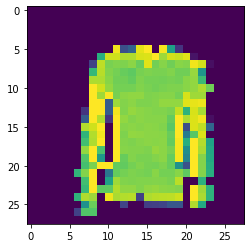

In [12]:
#random sample viz
i = np.random.randint(50)
x, y = next(iter(loaders['train']))
plt.imshow(x[i].view(28,28),), x.mean(), x.std()

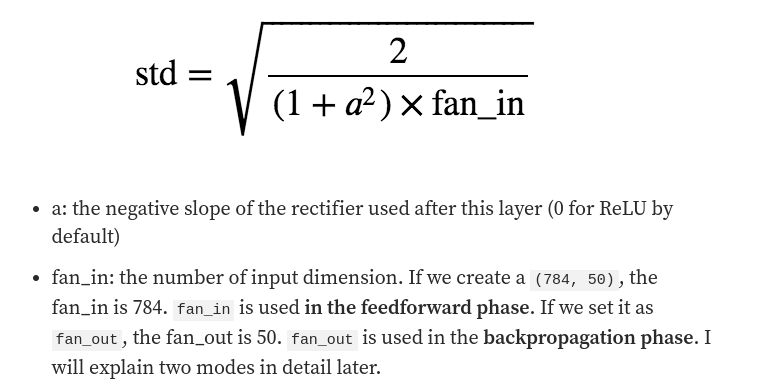

In [23]:
Image(filename='kaiming.png') 

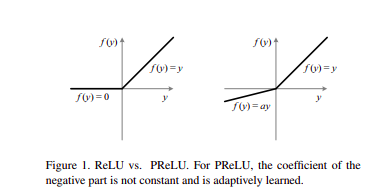

In [22]:
Image(filename='prelu.png') 

In [13]:
#VGG network definition 
class VGG(nn.Module):
  def __init__(self, features:nn.Module, num_classes:int=1000, init_weights:bool=True):
      super(VGG, self).__init__()
      self.features = features #features = Feature extraction
      self.avgpool = nn.AdaptiveAvgPool2d((1,1))
      self.classifier = nn.Sequential(nn.Linear(256, num_classes))

      if init_weights:
        self.initialize_weights()
  
  def forward(self, x):
    x = self.features(x) #features = Feature extraction
    x = self.avgpool(x)
    # print(x.shape)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0) 
      if isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0) 

cfgs: Dict[str, List[Union[int, str]]] = {
    'A':[64, 'M', 128, 128, 'M', 256, 256, 256],
    'B':[16, 'M', 256, 'M'],
    'firstPadding':2
}
# cfgs: Dict[str, List[Union[str, int]]] = {
#     'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
#     'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
# }



def make_layers(cfg:List[Union[int,str]], batch_norm:bool=False) -> nn.Sequential:
  layers:List[nn.Moduel] = []
  in_channels = 1
  in_padding = 5
  i = 0
  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
    else:
      v = cast(int, v)
      in_padding = 1
      if i == 5:
        in_padding = 2
      conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=in_padding)
      if batch_norm:
        layers += [conv2d, nn.BatchNorm2d(v), nn.PReLU(num_parameters=1)]
      else:
        layers += [conv2d, nn.PReLU(num_parameters=1)] #nn.PReLU(num_parameters=1) nn.ReLU(inplace=True)
      in_channels = v
    i += 1
  return nn.Sequential(*layers)


def selfDefineVgg(arch, cfg, batch_norm,  num_classes:int, **kwargs: Any) -> VGG:
    model = VGG(make_layers(arch[cfg], batch_norm=batch_norm), num_classes, **kwargs)
    return model
model = selfDefineVgg(cfgs, 'A', True, 10)
model = model.to(device)

In [14]:
#criterion, optimizer and scheduler definition
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas=(0.9,0.999), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1, verbose=False)

In [15]:
#trainer definition
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

In [16]:
#training
epochs = 100
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/100
train - loss:1.1318259487869406, accuracy0.5955991198239647
val - loss:1.074511180305481, accuracy0.6185
Time: 0.0m 16.79099750518799s
Epoch: 2/100
train - loss:0.8030721993440627, accuracy0.7095819163832766
val - loss:0.6220746892929078, accuracy0.7676000000000001
Time: 0.0m 33.61789155006409s
Epoch: 3/100
train - loss:0.6801476377240417, accuracy0.7540708141628325
val - loss:0.5638916806221008, accuracy0.8005
Time: 0.0m 50.55544686317444s
Epoch: 4/100
train - loss:0.60894848049152, accuracy0.7761152230446089
val - loss:0.5393811676979064, accuracy0.8220000000000001
Time: 1.0m 7.695700407028198s
Epoch: 5/100
train - loss:0.5009584677341009, accuracy0.8164832966593318
val - loss:0.3513127984046936, accuracy0.8712000000000001
Time: 1.0m 25.172892808914185s
Epoch: 6/100
train - loss:0.4710904983049108, accuracy0.8250850170034006
val - loss:0.3419974217414856, accuracy0.8792000000000001
Time: 1.0m 42.874516248703s
Epoch: 7/100
train - loss:0.4521483270662693, accuracy0.834166

Epoch: 54/100
train - loss:0.411514668370228, accuracy0.8488497699539908
val - loss:0.3164227695465088, accuracy0.8875000000000001
Time: 16.0m 32.62640428543091s
Epoch: 55/100
train - loss:0.4123633299178661, accuracy0.8484496899379875
val - loss:0.3166688562870026, accuracy0.8885000000000001
Time: 16.0m 51.30629277229309s
Epoch: 56/100
train - loss:0.4119566435431404, accuracy0.8478095619123824
val - loss:0.31616351590156555, accuracy0.8881
Time: 17.0m 10.090444564819336s
Epoch: 57/100
train - loss:0.410056315173767, accuracy0.8476495299059812
val - loss:0.3175269998550415, accuracy0.8869
Time: 17.0m 28.720391273498535s
Epoch: 58/100
train - loss:0.41060892577933467, accuracy0.8512102420484097
val - loss:0.3184417660176754, accuracy0.8869
Time: 17.0m 47.39241051673889s
Epoch: 59/100
train - loss:0.41384854033413493, accuracy0.848249649929986
val - loss:0.3180085075855255, accuracy0.8865000000000001
Time: 18.0m 6.161190032958984s
Epoch: 60/100
train - loss:0.413470396485942, accuracy0.

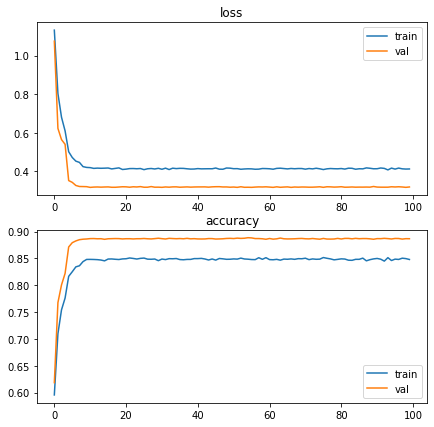

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

fig, axs = plt.subplots(2)

axs[0].plot([x for x in range(epochs)], losses['train'], label ='train')
axs[0].plot([x for x in range(epochs)], losses['val'], label='val')
axs[0].set_title('loss')
axs[0].legend()

axs[1].plot([x for x in range(epochs)], [y.cpu() for y in accuracies['train']], label ='train')
axs[1].plot([x for x in range(epochs)], [y.cpu() for y in accuracies['val']], label='val')
axs[1].set_title('accuracy')
axs[1].legend()